In [10]:
import yfinance as yf
import pandas as pd
import bnlearn as bn
from sklearn.preprocessing import StandardScaler

In [11]:
# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start='2019-02-01', end='2024-01-01')
#start='2001-01-01'

sp500_data['daily_return'] = sp500_data['Close'].pct_change() 
#sp500_data['volatility'] = sp500_data['daily_return'].rolling(window=20).std()

sp500_data['ma_200'] = sp500_data['Close'].rolling(window=200).mean() # for long term


# Calculate the 200-day moving return
#sp500_data['200_day_return'] = sp500_data['Close'].pct_change(periods=200)

[*********************100%%**********************]  1 of 1 completed


In [12]:
sp500 = sp500_data.dropna()
print(sp500.shape)
print(sp500.head())


(1038, 8)
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-11-14  3090.750000  3098.199951  3083.260010  3096.629883  3096.629883   
2019-11-15  3107.919922  3120.459961  3104.600098  3120.459961  3120.459961   
2019-11-18  3117.909912  3124.169922  3112.060059  3122.030029  3122.030029   
2019-11-19  3127.449951  3127.639893  3113.469971  3120.179932  3120.179932   
2019-11-20  3114.659912  3118.969971  3091.409912  3108.459961  3108.459961   

                Volume  daily_return       ma_200  
Date                                               
2019-11-14  3282090000      0.000837  2907.225742  
2019-11-15  3359800000      0.007695  2909.295392  
2019-11-18  3440140000      0.000503  2911.281191  
2019-11-19  3613670000     -0.000593  2913.193591  
2019-11-20  4041010000     -0.003756  2915.077841  


In [13]:
import pandas_datareader.data as pdr
import yfinance as yf
import pandas as pd

#only avaliable data from 2018-11-01	    

inflation = pdr.get_data_fred('CPIAUCSL', start='2019-11-01 ', end='2024-01-01')  # CPI for inflation	
unemployment = pdr.get_data_fred('UNRATE', start='2019-11-01 ', end='2024-01-01')
interest_rate = pdr.get_data_fred('FEDFUNDS', start='2019-11-01 ', end='2024-01-01')

# Rename columns for clarity
#gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True) 
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)

In [110]:
inflation.head()

Inflation
DATE                 
2019-11-01    257.879
2019-12-01    258.630
2020-01-01    258.906
2020-02-01    259.246
2020-03-01    258.150

In [14]:

#data from 2018-11-14
Inflation = inflation.resample('D').ffill().loc['2019-11-14':]
Unemployment = unemployment.resample('D').ffill().loc['2019-11-14':]
Interest_rate = interest_rate.resample('D').ffill().loc['2019-11-14':]

In [15]:
merged_data = sp500.join([Inflation, Unemployment, Interest_rate], how='left')
print(merged_data.shape)
print(merged_data.head())


(1038, 11)
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-11-14  3090.750000  3098.199951  3083.260010  3096.629883  3096.629883   
2019-11-15  3107.919922  3120.459961  3104.600098  3120.459961  3120.459961   
2019-11-18  3117.909912  3124.169922  3112.060059  3122.030029  3122.030029   
2019-11-19  3127.449951  3127.639893  3113.469971  3120.179932  3120.179932   
2019-11-20  3114.659912  3118.969971  3091.409912  3108.459961  3108.459961   

                  Volume  daily_return       ma_200  Inflation  Unemployment  \
Date                                                                           
2019-11-14  3.282090e+09      0.000837  2907.225742    257.879           3.6   
2019-11-15  3.359800e+09      0.007695  2909.295392    257.879           3.6   
2019-11-18  3.440140e+09      0.000503  2911.281191    257.879           3.6   
2019-11-19  3.613670e+09     -0.000

# convert index date into date
merged_data.index = pd.to_datetime(merged_data.index)

#shape of merged_data
merged_data.shape


In [114]:
# Finding rows with any NaNs
rows_with_any_nans = merged_data[merged_data.isna().any(axis=1)]
print("Rows with any NaNs:")
print(rows_with_any_nans)

Rows with any NaNs:
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, daily_return, ma_200, Inflation, Unemployment, Interest_Rate]
Index: []


from sklearn.preprocessing import StandardScaler
# Separating the features and target
#features = merged_data.drop(columns=['Close'])
target = merged_data['Close']
# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Converting the scaled features back to a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Adding the target column back to the scaled DataFrame
merged_data_scaled = pd.concat([features_scaled_df, target.reset_index(drop=True)], axis=1)

merged_data_scaled.head()

# correaltion matrix merged_data_scaled
correlation_matrix = merged_data_scaled.corr()
# heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [7]:

#slect the columns
merged_data = merged_data[[ 'Inflation', 'Unemployment', 'Interest_Rate', 'daily_return']]

# Separating the features and target
features = merged_data.drop(columns=['daily_return'])
target = merged_data['daily_return']
# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Converting the scaled features back to a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Adding the target column back to the scaled DataFrame
merged_data_scaled = pd.concat([features_scaled_df, target.reset_index(drop=True)], axis=1)

merged_data_scaled.head()


merged_data=merged_data_scaled

print(merged_data.head())
# Trying different method types and score types
DAG = bn.structure_learning.fit(merged_data, methodtype='hc', scoretype='k2')
#mehtodtype = hc is hill climbing
#scoretype = k2 is bayesian information criterion





   Inflation  Unemployment  Interest_Rate  daily_return
0  -1.247389     -0.606655      -0.110366      0.000837
1  -1.247389     -0.606655      -0.110366      0.007695
2  -1.247389     -0.606655      -0.110366      0.000503
3  -1.247389     -0.606655      -0.110366     -0.000593
4  -1.247389     -0.606655      -0.110366     -0.003756
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
[bnlearn] >Compute structure scores for model comparison (higher is better).


In [116]:
merged_data.shape

(1038, 4)

In [117]:
DAG['adjmat']

target         Inflation  Unemployment  Interest_Rate  daily_return
source                                                             
Inflation          False         False          False          True
Unemployment        True         False           True          True
Interest_Rate       True         False          False          True
daily_return       False         False          False         False

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


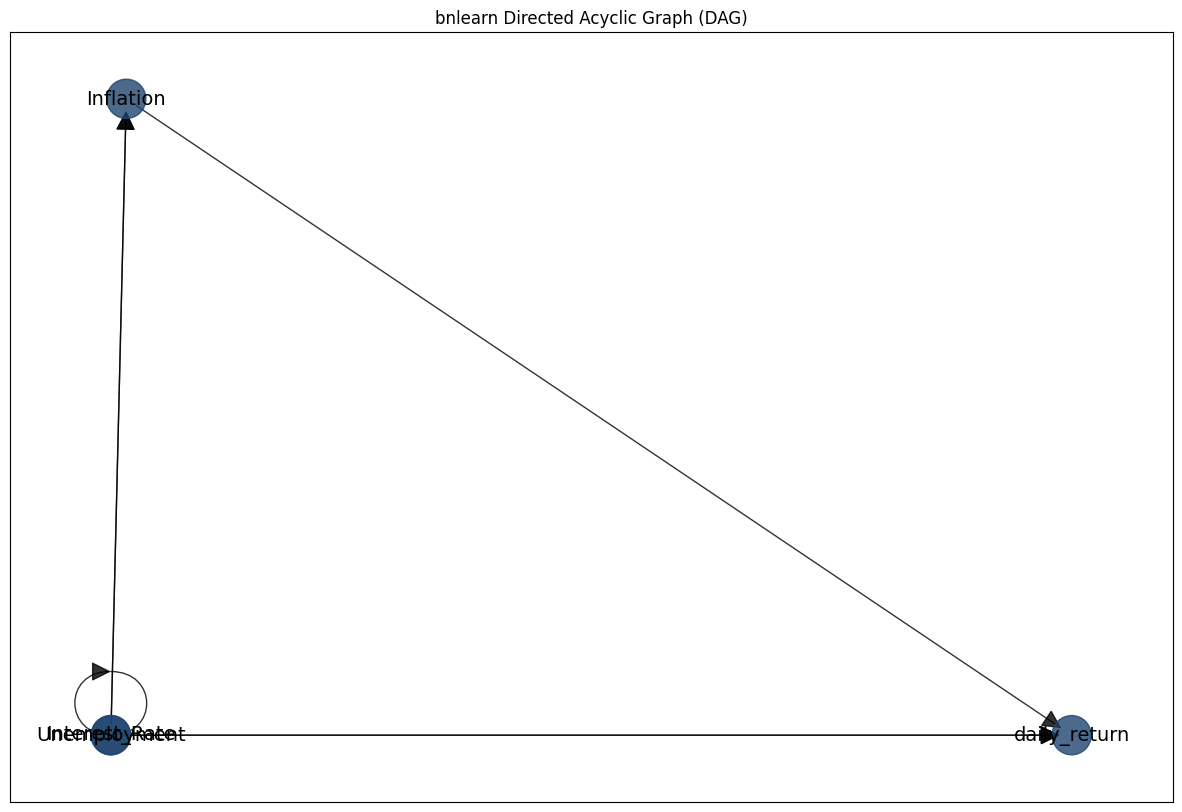

In [118]:
G = bn.plot(DAG)
#not good 



[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


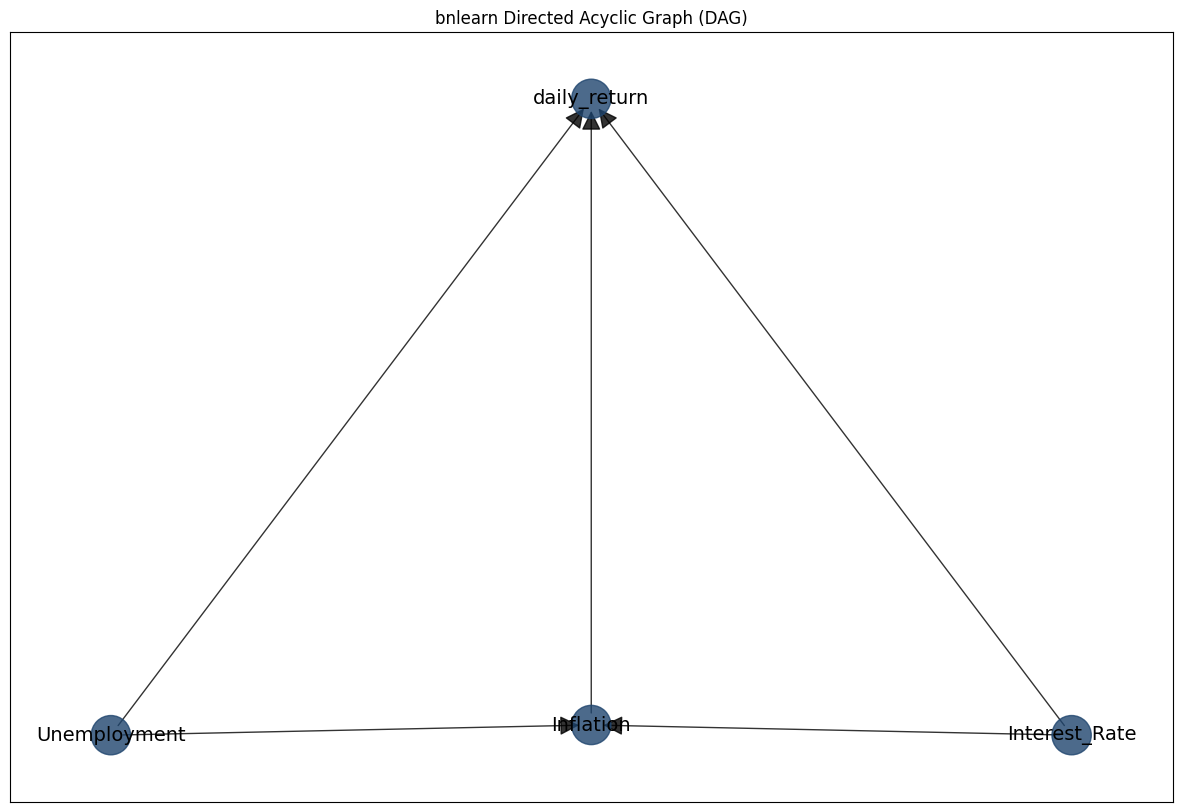

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'Inflation': array([-6.08681278e-17, -3.19016888e-01]),
  'daily_return': array([2.77106737e-16, 1.00000000e+00]),
  'Unemployment': array([-0.81659071, -0.34049156]),
  'Interest_Rate': array([ 0.81659071, -0.34049156])},
 'G': <networkx.classes.digraph.DiGraph at 0x31ea4a850>,
 'node_properties': {'Inflation': {'node_color': '#1f456e', 'node_size': 800},
  'daily_return': {'node_color': '#1f456e', 'node_size': 800},
  'Unemployment': {'node_color': '#1f456e', 'node_size': 800},
  'Interest_Rate': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('Inflation', 'daily_return'): {'color': '#000000',
   'weight': 1},
  ('Unemployment', 'Inflation'): {'color': '#000000', 'weight': 1},
  ('Unemployment', 'daily_return'): {'color': '#000000', 'weight': 1},
  ('Interest_Rate', 'Inflation'): {'color': '#000000', 'weight': 1},
  ('Interest_Rate', 'daily_return'): {'color': '#00000

In [119]:


edges = [('Inflation', 'daily_return'), 
         ('Unemployment', 'Inflation'), 
         ('Unemployment', 'daily_return'),
         ('Interest_Rate', 'Inflation'), 
         ('Interest_Rate', 'daily_return')]

# Import the DAG with the defined edges
DAG = bn.make_DAG(edges)

bn.plot(DAG)
# or just use the best DAG got from the structure learning

In [120]:
model_bayes = bn.parameter_learning.fit(DAG, merged_data, methodtype='bayes')
bn.print_CPD(model_bayes)


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Inflation:
+----------------------------------+-----+
| Interest_Rate                    | ... |
+----------------------------------+-----+
| Unemployment                     | ... |
+----------------------------------+-----+
| Inflation(-1.3567413540374285)   | ... |
+----------------------------------+-----+
| Inflation(-1.3417733657874837)   | ... |
+----------------------------------+-----+
| Inflation(-1.2945003669261388)   | ... |
+----------------------------------+-----+
| Inflation(-1.2473888931178534)   | ... |
+----------------------------------+-----+
| Inflation(-1.2327977966583752)   | ... |
+----------------------------------+-----+
| Inflation(-1.2189066420954728)   | ... |
+----------------------------------+-----+
| Inflation(-1.2069537881692576)   | ... |
+----------------------------------+-----+
| Inflation(-1.192093483288015)    | ... |
+----------------------------------+-----+
| 

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

def get_prob_distribution(row, target_variable):
    evidence = {
        'Inflation': row['Inflation'], 
        'Unemployment': row['Unemployment'], 
        'Interest_Rate': row['Interest_Rate']
    }
    result = bn.inference.fit(model_bayes, variables=[target_variable], evidence=evidence)
    return result.df







In [ ]:
# Step 5: Calculate the probability for each row in merged_data
def calculate_probabilities(data, target_variable):
    probabilities = []
    for index, row in data.iterrows():
        prob_dist = get_prob_distribution(row, target_variable)
        prob_close = prob_dist[prob_dist[target_variable] == row[target_variable]]['p'].values[0]
        probabilities.append(prob_close)
    return probabilities

# Example usage for 'Close'
probabilities_close = calculate_probabilities(merged_data, 'Close')
merged_data['Prob_Close'] = probabilities_close

# Display the first few rows to verify




[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+-----+---------+-------------+
|     |   Close |           p |
+=====+=========+=============+
|   0 | 3855.76 | 0.000525173 |
+-----+---------+-------------+
|   1 | 3861.59 | 0.000525173 |
+-----+---------+-------------+
|   2 | 3891.93 | 0.000525173 |
+-----+---------+-------------+
|   3 | 3916.64 | 0.000525173 |
+-----+---------+-------------+
|   4 | 3918.32 | 0.000525173 |
+-----+---------+-------------+
|   5 | 3919.29 | 0.000525173 |
+-----+---------+-------------+
|   6 | 3936.97 | 0.000525173 |
+-----+---------+-------------+
|   7 | 3948.72 | 0.000525173 |
+-----+---------+-------------+
|   8 | 3951.39 | 0.000525173 |
+-----+---------+-------------+
|   9 | 3951.57 | 0.000525173 |
+-----+---------+-------------+
|  10 | 3960.28 | 0.000525173 |
+-----+---------+-------------+
|  11 | 3970.04 | 0.046827    |
+-----+---------+-------------+


In [8]:
print(merged_data.head())
#0.046827
#contains the calculated probabilities for the 'Close' variable for each row, given the evidence from that row. 

   Inflation  Unemployment  Interest_Rate  daily_return
0  -1.247389     -0.606655      -0.110366      0.000837
1  -1.247389     -0.606655      -0.110366      0.007695
2  -1.247389     -0.606655      -0.110366      0.000503
3  -1.247389     -0.606655      -0.110366     -0.000593
4  -1.247389     -0.606655      -0.110366     -0.003756


In [ ]:
#check the assupmtion of linear regression: residuals are normally distributed

In [81]:

merged_data = merged_data.drop(columns=['Close'])
merged_data.head()

Open         High          Low    Adj Close        Volume  \
Date                                                                           
2000-10-16  1374.170044  1379.479980  1365.060059  1374.619995  1.005400e+09   
2000-10-17  1374.619995  1380.989990  1342.339966  1349.969971  1.161500e+09   
2000-10-18  1349.969971  1356.650024  1305.790039  1342.130005  1.441700e+09   
2000-10-19  1342.130005  1389.930054  1342.130005  1388.760010  1.297900e+09   
2000-10-20  1388.760010  1408.469971  1382.189941  1396.930054  1.177400e+09   

            daily_return       ma_200  Inflation  Unemployment  Interest_Rate  
Date                                                                           
2000-10-16      0.000327  1444.783248      173.9           3.9           6.51  
2000-10-17     -0.017932  1444.256998      173.9           3.9           6.51  
2000-10-18     -0.005808  1443.970548      173.9           3.9           6.51  
2000-10-19      0.034743  1443.903798      173.9           3.9           6.51  
2000-10-20      0.005883  1443.871199      173.9           3.9           6.51

In [89]:
X_with_const = merged_data.drop('daily_return',axis=1)

X_with_const.insert(0,'intercept',1)

In [90]:
mod = sm.OLS(merged_data.daily_return,X_with_const)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1581.
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:12:26   Log-Likelihood:                 20996.
No. Observations:                5838   AIC:                        -4.197e+04
Df Residuals:                    5828   BIC:                        -4.191e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept     -5.631e-05      0.001     -0.041

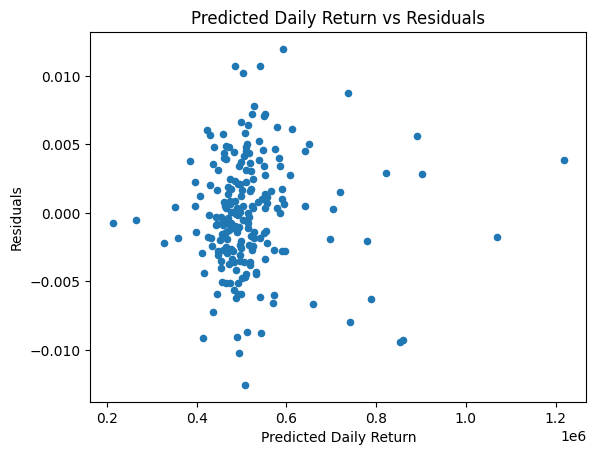

In [16]:
#train daa of merged_data
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#get train data
train_data = merged_data.iloc[:int(0.8*len(merged_data))]
test_data = merged_data.iloc[int(0.8*len(merged_data)):]


X_with_const = merged_data.drop('daily_return',axis=1)
X_with_const.insert(0,'intercept',1)
train_model = sm.OLS(merged_data.daily_return,X_with_const, data=train_data).fit()
test_data['predicted_daily_return'] = train_model.predict(test_data)
# Create the summary DataFrame
mod_summary = pd.DataFrame({
    'preds': test_data['predicted_daily_return'],
    'resids': train_model.resid
})

# Plotting
mod_summary.plot('preds', 'resids', kind='scatter')
plt.xlabel('Predicted Daily Return')
plt.ylabel('Residuals')
plt.title('Predicted Daily Return vs Residuals')
plt.show()
#One assumption of a linear regression model is that the variance of the residual is the same for all values of X
#violate the assu

get more data 

In [17]:
import yfinance as yf
import pandas as pd
import bnlearn as bn
from sklearn.preprocessing import StandardScaler


# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')
#start='2001-01-01'

#sp500_data['daily_return'] = sp500_data['Close'].pct_change() 
#sp500_data['volatility'] = sp500_data['daily_return'].rolling(window=20).std()

sp500_data['ma_200'] = sp500_data['Close'].rolling(window=200).mean() # for long term

sp500 = sp500_data.dropna()
sp500.head()



[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-10-16  1374.170044  1379.479980  1365.060059  1374.619995  1374.619995   
2000-10-17  1374.619995  1380.989990  1342.339966  1349.969971  1349.969971   
2000-10-18  1349.969971  1356.650024  1305.790039  1342.130005  1342.130005   
2000-10-19  1342.130005  1389.930054  1342.130005  1388.760010  1388.760010   
2000-10-20  1388.760010  1408.469971  1382.189941  1396.930054  1396.930054   

                Volume       ma_200  
Date                                 
2000-10-16  1005400000  1444.783248  
2000-10-17  1161500000  1444.256998  
2000-10-18  1441700000  1443.970548  
2000-10-19  1297900000  1443.903798  
2000-10-20  1177400000  1443.871199

In [18]:
import pandas_datareader.data as pdr
import yfinance as yf
import pandas as pd

#only avaliable data from 2018-11-01	    

inflation = pdr.get_data_fred('CPIAUCSL', start='2000-10-01	 ', end='2024-01-01')  # CPI for inflation	
unemployment = pdr.get_data_fred('UNRATE', start='2000-01-01 ', end='2024-01-01')
interest_rate = pdr.get_data_fred('FEDFUNDS', start='2000-01-01 ', end='2024-01-01')

# Rename columns for clarity
#gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True) 
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
#data from 2018-11-14
Inflation = inflation.resample('D').ffill().loc['2000-10-16':]
Unemployment = unemployment.resample('D').ffill().loc['2000-10-16':]
Interest_rate = interest_rate.resample('D').ffill().loc['2000-10-16':]